In [ ]:
import numpy as np
import os
import pandas as pd
import sys
import torch


from matplotlib import pyplot as plt


project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)
import config

# from experiments.MNIST import ExperimentADeLEn, ExperimentSupervised, ExperimentSVM
from experiments.MedMNIST import ExperimentADeLEn, ExperimentSupervised, ExperimentSVM

# Pollution experiments using MNIST


In [ ]:
pollution_exp = [0, .05, .1, .2]

## Table

In [ ]:
from itertools import chain
def generate_multi_df(data:list, parent_index:list, child_index:list) -> pd.DataFrame:
    index_names = [
        [x for x in parent_index for _ in child_index],
        child_index*len(parent_index)
    ]

    tuples = list(zip(*index_names))
    index = pd.MultiIndex.from_tuples(tuples)
    return pd.DataFrame(chain.from_iterable(data), index=index)

In [ ]:
exp = ExperimentADeLEn(.1, .2, 2)
result_dir = exp.config()['save_result_dir']
df = pd.read_csv(os.path.join(result_dir, 'metrics.csv'), index_col=0)
acc = df['Accuracy'].mean(), df['Accuracy'].std()
prec = df['Precision'].mean(), df['Precision'].std()
rec = df['Recall'].mean(), df['Recall'].std()
f1 = df['F1'].mean(), df['F1'].std()
auc = df['AUC'].mean(), df['AUC'].std()


data = [acc, prec, rec, f1, auc]
parent_index = ['Acc', 'Prec', 'Recall', 'F1', 'AUC']
child_index = ['Mean', 'Std']
df = generate_multi_df(data, parent_index, child_index).T
df

In [ ]:
exp = ExperimentADeLEn(.1, .2, 2)
result_dir = exp.config()['save_result_dir']
df = pd.read_csv(os.path.join(result_dir, 'metrics.csv'), index_col=0)
df['Accuracy'].mean(), df['Accuracy'].std(),

In [ ]:
(df['Accuracy'].mean(), df['Accuracy'].std()), (df['Precision'].mean(), df['Precision'].std()), (df['Recall'].mean(), df['Recall'].std()), (df['F1'].mean(), df['F1'].std()), (df['AUC'].mean(), df['AUC'].std())

In [ ]:
exp = ExperimentSupervised(.1, .2)
result_dir = exp.config()['save_result_dir']
df = pd.read_csv(os.path.join(result_dir, 'metrics.csv'), index_col=0)

In [ ]:
(df['Accuracy'].mean(), df['Accuracy'].std()), (df['Precision'].mean(), df['Precision'].std()), (df['Recall'].mean(), df['Recall'].std()), (df['F1'].mean(), df['F1'].std()), (df['AUC'].mean(), df['AUC'].std())

## Images

In [ ]:
def generate_score_histogram(score_df:pd.DataFrame, normal_bins=10, anomaly_bins=10):
    from matplotlib.ticker import MaxNLocator

    with plt.style.context('seaborn-colorblind'):
        fig = plt.figure(figsize=(5, 4))
        ax = plt.gca()
        ax.hist(score_df['Normal'], bins=normal_bins, alpha=.7, label='Normal')
        ax.hist(score_df['Anomaly'], bins=anomaly_bins, alpha=.7, label='Anomaly')
        ax.legend(fontsize='x-large')
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5)) 
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_ylabel('Samples', fontsize='xx-large')
        ax.set_xlabel('Score', fontsize='xx-large')
        ax.tick_params(axis='both', which='major', labelsize='x-large')
        ax.grid()
        
        return fig
    
def plot_reconstructed(model, r0=(-6, 6), r1=(-6, 6), n=12):
    model.eval()
    w = 28
    img = np.zeros((n*w, n*w))

    fig = plt.figure(figsize=(5, 5))

    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = torch.tanh(model.decode_path(z)) # ADeLEn
            x_hat = x_hat.reshape(w, w).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    
    plt.xlabel('$\mathcal{N}(0, \sigma_1)$', fontsize='xx-large')
    plt.ylabel('$\mathcal{N}(0, \sigma_2)$', fontsize='xx-large')
    plt.tick_params(axis='both', which='major', labelsize='x-large')
    plt.imshow(img, extent=[*r0, *r1], cmap='viridis')

    return fig

### ADeLEn

In [ ]:
for d in [2, 5, 10]:
    for pollution in pollution_exp:
        exp = ExperimentADeLEn(.1, pollution, d)
        result_dir = exp.config()['save_result_dir']
        img_dir = exp.config()['save_imgs_dir']

        df = pd.read_csv(os.path.join(result_dir, 'metrics.csv'), index_col=0)
        idx = df['AUC'].apply(lambda x: abs(x - df['AUC'].mean())).idxmin()

        score_df = pd.read_pickle(os.path.join(result_dir, 'sample_score.pkl'))[f'It {idx+1}']
        fig = generate_score_histogram(score_df)
        fig.savefig(os.path.join(img_dir, f'score_histogram_{pollution}.pdf'), bbox_inches='tight')
        plt.close(fig)

#### Reconstructions

In [ ]:
for pollution in pollution_exp:
    exp = ExperimentADeLEn(.1, pollution, d=2)
    img_dir = exp.config()['save_imgs_dir']
    exp.run()

    fig = plot_reconstructed(exp.model, r0=(-6, 6), r1=(-6, 6), n=10)
    fig.savefig(os.path.join(img_dir, f'reconstruction_{pollution}.pdf'), bbox_inches='tight')
    plt.close(fig)

### Supervised

In [ ]:
for pollution in pollution_exp:
    exp = ExperimentSupervised(.1, pollution)
    result_dir = exp.config()['save_result_dir']
    img_dir = exp.config()['save_imgs_dir']

    df = pd.read_csv(os.path.join(result_dir, 'metrics.csv'), index_col=0)
    idx = df['AUC'].apply(lambda x: abs(x - df['AUC'].mean())).idxmin()

    score_df = pd.read_pickle(os.path.join(result_dir, 'sample_score.pkl'))[f'It {idx+1}']
    score_df['Normal'] = score_df['Normal'].apply(lambda x: x.item() if x is not None else x)
    score_df['Anomaly'] = score_df['Anomaly'].apply(lambda x: x.item() if x is not None else x)
    
    fig = generate_score_histogram(score_df, normal_bins=(1 if pollution==.2 else 10))
    fig.savefig(os.path.join(img_dir, f'score_histogram_{pollution}.pdf'), bbox_inches='tight')
    plt.close(fig)

# SVM

In [ ]:
for pollution in pollution_exp:
    exp = ExperimentSVM(.1, pollution)
    result_dir = exp.config()['save_result_dir']
    img_dir = exp.config()['save_imgs_dir']

    df = pd.read_csv(os.path.join(result_dir, 'metrics.csv'), index_col=0)
    idx = df['AUC'].apply(lambda x: abs(x - df['AUC'].mean())).idxmin()

    score_df = pd.read_pickle(os.path.join(result_dir, 'sample_score.pkl'))[f'It {idx+1}']
    
    fig = generate_score_histogram(score_df)
    fig.savefig(os.path.join(img_dir, f'score_histogram_{pollution}.pdf'), bbox_inches='tight')
    plt.close(fig)

# Number of labels

In [ ]:
n_labels = [.05, .1, .2, .25, .5]
pollution = .05

for d in [2, 5, 10]:
    for labels in n_labels:
        exp = ExperimentADeLEn(labels, pollution, d)
        result_dir = exp.config()['save_result_dir']
        img_dir = exp.config()['save_imgs_dir']

        df = pd.read_csv(os.path.join(result_dir, 'metrics.csv'), index_col=0)
        idx = df['AUC'].apply(lambda x: abs(x - df['AUC'].mean())).idxmin()

        score_df = pd.read_pickle(os.path.join(result_dir, 'sample_score.pkl'))[f'It {idx+1}']
        fig = generate_score_histogram(score_df)
        fig.savefig(os.path.join(img_dir, f'score_histogram_{labels}_{pollution}.pdf'), bbox_inches='tight')
        plt.close(fig)


In [116]:
labels = n_labels[3]
exp_2 = ExperimentADeLEn(labels, pollution, 2)
exp_5 = ExperimentADeLEn(labels, pollution, 5)
exp_10 = ExperimentADeLEn(labels, pollution, 10)


result_dir_2 = exp_2.config()['save_result_dir']
result_dir_5 = exp_5.config()['save_result_dir']
result_dir_10 = exp_10.config()['save_result_dir']
img_dir_2 = exp_2.config()['save_imgs_dir']

df_2 = pd.read_csv(os.path.join(result_dir_2, 'metrics.csv'), index_col=0)
df_5 = pd.read_csv(os.path.join(result_dir_5, 'metrics.csv'), index_col=0)
df_10 = pd.read_csv(os.path.join(result_dir_10, 'metrics.csv'), index_col=0)

Using downloaded and verified file: data/pneumoniamnist.npz
Using downloaded and verified file: data/pneumoniamnist.npz
Using downloaded and verified file: data/pneumoniamnist.npz
Using downloaded and verified file: data/pneumoniamnist.npz
Using downloaded and verified file: data/pneumoniamnist.npz
Using downloaded and verified file: data/pneumoniamnist.npz


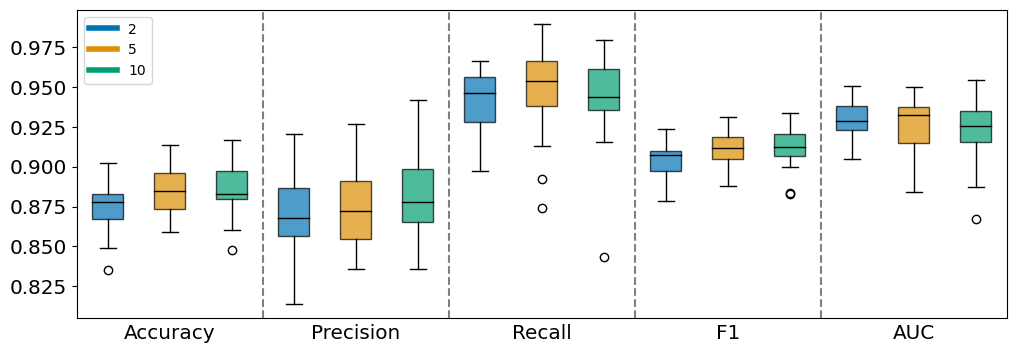

In [117]:
import seaborn as sns
colors = sns.color_palette("colorblind", 3)

fig = plt.figure(figsize=(12, 4))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
for i, metric in enumerate(metrics):
    for j, exp in enumerate([df_2, df_5, df_10]):
        data = exp[metric]
        plt.boxplot(data, positions=[3*i + j+1], widths=0.5, patch_artist=True, 
                    boxprops=dict(facecolor=colors[j], alpha=.7),
                    medianprops=dict(color='black', linewidth=1))
        if j == 2 and i < len(metrics) - 1:
            plt.axvline(x=3*i + j+1.5, linestyle='--', color='gray')

ylim = plt.ylim()
margin = (ylim[1] - ylim[0]) * 0.02  # Margen basado en el rango del eje y
for i, metric in enumerate(metrics):
    plt.text(3*i + 2, ylim[0] - margin, metric, ha='center', va='top', fontsize='x-large')

    # plt.text(3*i + 2, plt.ylim()[0] - (plt.ylim()[1] - plt.ylim()[0]) * 0.05, metric, ha='center', va='top')
plt.legend([plt.Line2D([0], [0], color=color, lw=4) for color in colors], ['2', '5', '10'])
plt.xticks([])
plt.yticks(fontsize='x-large')

plt.show()

In [74]:
dim

'10'

In [ ]:
# Configuración de la figura
plt.figure(figsize=(12, 6))

# Obtener una paleta de colores para daltonicos de Seaborn
colors = sns.color_palette("colorblind", 3)

# Posiciones iniciales para los boxplots
positions = [1, 2, 3]  # Posiciones iniciales para la primera métrica
width = 0.5  # Ancho de cada boxplot

# Dibujar los boxplots manualmente
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']):
    for j, exp in enumerate(['2', '5', '10']):
        # Filtrar datos para cada experimento y métrica
        subset = df[(df['Dimension'] == exp) & (df['Métrica'] == metric)]
        plt.boxplot(subset['Valor'], positions=[positions[j]], widths=width, patch_artist=True, boxprops=dict(facecolor=colors[j]))

    # Dibujar línea discontinua entre las métricas si no es la última
    if i < 2:
        plt.axvline(x=positions[-1] + 0.5, color='gray', linestyle='--')

    # Actualizar posiciones para la siguiente métrica
    positions = [p + 4 for p in positions]  # Aumentar 4 posiciones para la siguiente métrica

# Configurar los ejes
plt.xticks([2, 6, 10], ['Precisión', 'Recall', 'F1-score'])
plt.xlim(0, positions[-1] + 1)
plt.title('Comparación de Métricas por Experimento')
plt.ylabel('Valor de la Métrica')
plt.xlabel('Tipo de Métrica')

# Leyenda
plt.legend([plt.Line2D([0], [0], color=color, lw=4) for color in colors], ['Exp1', 'Exp2', 'Exp3'])
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
df